In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import shutil
import datetime
from textwrap import wrap
from mastodon import Mastodon

In [2]:
def retrieve_entry(pdb_id):
    
    '''
    Given a PDB id (str), this function returns
    an image of the PDB assembly.
    '''
    
    url = 'https://cdn.rcsb.org/images/structures/' + pdb_id.lower() + '_assembly-1.jpeg'
    filename = '../img/' + pdb_id.lower() + '.jpg'
    
    r = requests.get(url, stream = True)

    if r.status_code == 200:
        with open(filename,'wb') as f:
            shutil.copyfileobj(r.raw, f)
    else:
        print("Image Couldn't be retrieved")
    
    return filename

In [3]:
# load in gene2lit
gene2lit = pd.read_csv('../data/pubtator_title_or_abstract_in_any_gene2pubmed_paper_no_reviews.csv')

In [4]:
# load in gene spreadsheet
gene_info = pd.read_csv('../data/gene_info_221228.csv')

In [5]:
# get unique genes from gene info, subtract previously posted genes
genes = list((
    set(np.unique(gene_info['gene_ncbi'])) - 
    set(pd.read_csv('../data/previous_genes.txt', header=None)[0].values)
))

In [16]:
gene_otd = 1956 #np.random.choice(genes)

gene_slice = gene_info[gene_info['gene_ncbi'] == gene_otd]

gene_symbol = gene_slice['symbol_ncbi'].values[0]
gene_name = gene_slice['description'].values[0]
gene_type = gene_slice['type_of_gene'].values[0]
gene_locus = gene_slice['map_location'].values[0]
dbxrefs = gene_slice['dbxrefs'].values[0]
synonyms = gene_slice['synonyms'].values[0]

pdb_id = gene_slice['pdb_id'].values[0]
structure_title = gene_slice['structure_title'].values[0]

has_pdb =  type(pdb_id) == str

gene2lit_slice = gene2lit[gene2lit['gene_ncbi'] == gene_otd]

has_pubs = len(gene2lit_slice) > 0

groupby_year = gene2lit_slice.groupby('year').count().reindex(range(1950,2021)).fillna(0.0)['pubmed_id']

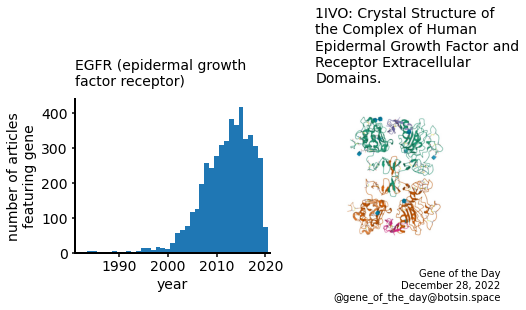

In [17]:
fig, axes = plt.subplots(figsize=(7,4), nrows=1, ncols=2, gridspec_kw={'width_ratios':[1,1]})

if has_pubs:
    axes[0].bar(height=groupby_year, x=groupby_year.index, width=1)
    min_year = gene2lit_slice['year'].min() - 2
    min_year = np.min([min_year, 2009])
    axes[0].set_xlim([min_year, 2021])
    axes[0].tick_params(labelsize=14, axis='both', width=1.5)
    axes[0].set_xlabel('year', fontsize=14)
    axes[0].set_ylabel('number of articles\nfeaturing gene', fontsize=14)

    title_str = gene_symbol + ' (' + gene_name + ')'
    title_str = '\n'.join(wrap(title_str, width=28))
    axes[0].set_title(title_str, x=0, y=1.05, ha='left', fontsize=14)

    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    [axes[0].spines[i].set_linewidth(2) for i in axes[0].spines]
else:
    axes[0].axis(False)
    except_str = 'No articles mentioning ' + gene_symbol + \
    ' (' + gene_name + ')'+ ' in title or abstract found.'
    axes[0].text(s='\n'.join(wrap(except_str, width=30)), y=0.5, x=0.5, 
                 ha='center', fontsize=14, va='center')


if has_pdb:
    filename = retrieve_entry(pdb_id)
    img = mpl.image.imread(filename)
    axes[1].imshow(img)
    axes[1].axis(False)
    title_str = pdb_id + ': ' + structure_title
    axes[1].set_title('\n'.join(wrap(title_str, width=28)), fontsize=14, va='bottom', ha='left', x=0, y=1.05)
else:
    axes[1].axis(False)
    except_str = 'No experimental protein structure found in PDB'
    if gene_type != 'protein-coding':
        except_str = except_str + ' (gene is probably not protein-coding).'
    else:
        except_str = except_str + '.'
    axes[1].text(s='\n'.join(wrap(except_str, width=28)), y=0.5, x=0.5, 
                 ha='center', fontsize=14, va='center')

# Signature
today = datetime.date.today()
today_str = today.strftime("%B %d, %Y")
fig.text(s='Gene of the Day\n' + today_str + '\n@gene_of_the_day@botsin.space', x=1,y=0, ha='right', va='bottom')

fig.tight_layout()

plt.savefig('../img/' + str(gene_otd) + '.png', dpi=200, bbox_inches='tight', facecolor='white', transparent=False)

In [18]:
n_articles = len(gene2lit_slice)

if n_articles == 1:
    plural_str = ' features'
else:
    plural_str = 's feature'

status_str = ''
status_str += 'The gene of the day is ' + gene_symbol + ' (' + gene_name + ')!\n'
status_str += '{:,}'.format(n_articles) + \
' article' + plural_str + ' this gene in the title or abstract.\n\n'

status_str += 'Entrez ID: ' + str(gene_otd) + '\n'
status_str += 'Locus: ' + gene_locus + '\n'
status_str += 'Type of gene: ' + gene_type + '\n'
status_str += 'Synonyms: ' + synonyms + '\n'
status_str += 'Other designations: ' + dbxrefs

In [19]:
print(status_str)

The gene of the day is EGFR (epidermal growth factor receptor)!
4,686 articles feature this gene in the title or abstract.

Entrez ID: 1956
Locus: 7p11.2
Type of gene: protein-coding
Synonyms: ERBB|ERBB1|ERRP|HER1|NISBD2|PIG61|mENA
Other designations: MIM:131550|HGNC:HGNC:3236|Ensembl:ENSG00000146648|AllianceGenome:HGNC:3236


In [20]:
# initialize mastodon
mastodon = Mastodon(
    access_token = '../token.secret',
    api_base_url = 'https://botsin.space/'
)

In [21]:
# add media and post
media = mastodon.media_post('../img/' + str(gene_otd) + '.png')
status = mastodon.status_post(status_str, media_ids=media)

In [22]:
# write gene ID to previous genes
f = open('../data/previous_genes.txt', 'a')
f.write(str(gene_otd) + '\n')
f.close()

In [23]:
print(gene_otd)

1956
